In [1]:
#!pip install PIL
#!pip install tensorboardX

In [2]:
import os
import glob
import numpy as np
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from tqdm import tqdm
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import pprint
import math
from lamb import Lamb

In [3]:
#from google.colab import drive
#drive.mount('/content/drive')

In [4]:
#Constants
dataset_path = './Data-L'
batch_size = 32
epoch = 150
load_workers = 2 
lr = 1e-3
weight_decay = 1e-5
cuda = torch.device("cuda:5")
print(cuda)
best_epoch = 0
tag = 1
meta_beta = 10.0
m = 3

cuda:5


In [5]:
figure_configuration_names = ['center_single', 'distribute_four', 'in_distribute_four_out_center_single', 'left_center_single_right_center_single']
#figure_configuration_names = ['center_single']

class ToTensor(object):
    def __call__(self, sample):
        return torch.tensor(sample, dtype=torch.float32)

class RAVENdataset(Dataset):
    def __init__(self, root_dir, dataset_type, figure_configurations, img_size, transform=None, shuffle=False):
        self.root_dir = root_dir
        self.transform = transform
        self.file_names = []
        for idx in figure_configurations:
            tmp = [f for f in glob.glob(os.path.join(root_dir, figure_configuration_names[idx], "*.npz")) if dataset_type in os.path.basename(f)]
            self.file_names += tmp
        self.img_size = img_size   
        self.shuffle = shuffle
        self.switch = [3,4,5,0,1,2,6,7]         

    def __len__(self):
        return len(self.file_names)

    def __getitem__(self, idx):
        data_path = self.file_names[idx]
        data = np.load(data_path)
        image = data["image"].reshape(16, 160, 160)
        target = data["target"]
        meta_target = data["meta_target"]

        if self.shuffle:
            context = image[:8, :, :]
            choices = image[8:, :, :]
            indices = np.arange(8)
            np.random.shuffle(indices)
            new_target = np.where(indices == target)[0][0]
            new_choices = choices[indices, :, :]
            switch_2_rows = np.random.rand()            
            if switch_2_rows < 0.5:                
                context = context[self.switch, :, :]
            image = np.concatenate((context, new_choices))
            target = new_target

        resize_image = []
        for idx in range(0, 16):
            resize_image.append(np.array(Image.fromarray(image[idx,:,:]).resize([self.img_size, self.img_size])))
            #resize_image.append(misc.imresize(image[idx,:,:], (self.img_size, self.img_size)))
        resize_image = np.stack(resize_image) 

        del data
        if self.transform:
            resize_image = self.transform(resize_image)           
            target = torch.tensor(target, dtype=torch.long)
            meta_target = self.transform(meta_target) 

        return resize_image, target, meta_target

In [6]:
    img_size = 80
    train_figure_configurations = [0]
    val_figure_configurations = train_figure_configurations
    test_figure_configurations = [0]
    print(dataset_path)
    train = RAVENdataset(dataset_path, "train", train_figure_configurations, img_size, transform=transforms.Compose([ToTensor()]), shuffle = True)
    valid = RAVENdataset(dataset_path, "val", val_figure_configurations, img_size, transform=transforms.Compose([ToTensor()]))
    test = RAVENdataset(dataset_path, "test", test_figure_configurations, img_size, transform=transforms.Compose([ToTensor()]))
  

./Data-L


In [7]:
trainloader = DataLoader(train, batch_size=batch_size, shuffle=True, num_workers=load_workers)
validloader = DataLoader(valid, batch_size=batch_size, shuffle=False, num_workers=load_workers)
testloader = DataLoader(test, batch_size=batch_size, shuffle=False, num_workers=load_workers)

In [8]:
# model adapted from WReN and MLRN code: 
# WReN: https://github.com/Fen9/WReN/tree/master/models
# MLRN: https://arxiv.org/abs/2003.11608

In [9]:
def getCombinations(inputTensor, N, c, d):#input shape=(batch_size, obj_count, obj_dim) #batch_size=N, obj_count=c, obj_dim=d
    tensorA = inputTensor.reshape(N, 3, 3, d)
    tensorB = torch.roll(tensorA,1,1)
    tensorC = torch.roll(tensorB,1,1)
    tensorX = tensorA.transpose(1,2)
    tensorY = torch.roll(tensorX,1,1)
    tensorZ = torch.roll(tensorY,1,1)
    return torch.cat((torch.cat((tensorA,tensorA),3), torch.cat((tensorB,tensorA),3), torch.cat((tensorB,tensorC),3), 
                      torch.cat((tensorX,tensorX),3), torch.cat((tensorY,tensorX),3), torch.cat((tensorY,tensorZ),3)),1)
    

def getSecondaryCombinations(inputTensor, N, c, d):
  tensorA = inputTensor.reshape(N,1,c,d).expand(N,c,c,d)
  tensorB = tensorA.transpose(1, 2)

  return torch.cat((tensorB, tensorA), 3)

In [10]:
## Optimizer related changes
def add_module_params_with_decay(module, weight_decay, param_groups):
    group_with_decay= []
    group_without_decay = []
    for name, param in module.named_parameters():
        if not param.requires_grad: continue
        if name == 'bias' or name.endswith('bias'):
            group_without_decay.append(param)
        else:
            group_with_decay.append(param)
    param_groups.append({"params": group_with_decay, "weight_decay":weight_decay})
    param_groups.append({"params": group_without_decay})

optimizer_param_groups = []

In [11]:
class BasicModel(nn.Module):
    def __init__(self, args):
        super(BasicModel, self).__init__()
        self.name = args['model']

    def load_model(self, path, epoch):
        self.state_dict = torch.load(path+'{}_epoch_{}.pth'.format(self.name, epoch))

    def save_model(self, path, epoch):
        torch.save(self.state_dict(), path+'{}_epoch_{}.pth'.format(self.name, epoch))

    def compute_loss(self, output, target, meta_target):
        pass

    def train_(self, input, target, meta_target):
        self.optimizer.zero_grad()
        output = self(input)
        loss = self.compute_loss(output, target, meta_target)
        loss.backward()
        self.optimizer.step()
        pred = output[0].data.max(1)[1]
        correct = pred.eq(target.data).cpu().sum().numpy()
        accuracy = correct * 100. / target.size()[0]
        return loss.item(), accuracy

    def validate_(self, input, target, meta_target):
        output = self(input)
        loss = self.compute_loss(output, target, meta_target)
        pred = output[0].data.max(1)[1]
        correct = pred.eq(target.data).cpu().sum().numpy()
        accuracy = correct * 100. / target.size()[0]
        return loss.item(), accuracy

    def test_(self, input, target, meta_target):
        output = self(input)
        pred = output[0].data.max(1)[1]
        correct = pred.eq(target.data).cpu().sum().numpy()
        accuracy = correct * 100. / target.size()[0]
        return accuracy

In [12]:
class WReN(BasicModel):
    def __init__(self, args):
        super(WReN, self).__init__(args)
        self.relation_network_depth = args['m']

        self.g_dim = 512
        self.h_dim = 256
        self.f_dim = 256

        self.use_mag_enc = True #switch between scalar input and magnitude encoded input
        self.mag_enc_type_relu = False #switch between gaussian magnitude encoding and relu based magnitude encoding

        self.magnitude_encoding_dim = 20
        #model
        #magnitude encoding
        self.input_scale = 2.0/255.0
        self.input_offset = -1.0
        std_dev = 0.28
        self.input_encoding_variance_inv = 1.0 / (math.sqrt(2.0) * std_dev)
        self.normalization_factor = 1.0 / (math.sqrt(2*math.pi) * std_dev)
        self.mag_scale = torch.nn.Parameter(torch.linspace(-1.0, 1.0, steps=self.magnitude_encoding_dim), requires_grad=False)

        if self.use_mag_enc:
            conv_input_dim = self.magnitude_encoding_dim
        else:
            conv_input_dim = 1

        self.conv = torch.nn.Sequential(
            torch.nn.Conv2d(conv_input_dim, 32, 3, stride=2), 
            torch.nn.LeakyReLU(),
            torch.nn.Conv2d(32, 32, 3, stride=2), 
            torch.nn.LeakyReLU(),
            torch.nn.Conv2d(32, 32, 3, stride=2), 
            torch.nn.LeakyReLU(),
            torch.nn.Conv2d(32, 32, 3, stride=2), 
            torch.nn.LeakyReLU()
        )
        self.post_cnn_linear = torch.nn.Linear(32*4*4, 256-9)

        self.tag_matrix = torch.nn.Parameter(torch.eye(9).repeat(8, 1), requires_grad=False)

        self.g = torch.nn.Sequential(
                torch.nn.Linear(2*256, self.g_dim), 
                torch.nn.LeakyReLU(),
                torch.nn.Linear(self.g_dim, self.g_dim), 
                torch.nn.LeakyReLU(),
                torch.nn.Linear(self.g_dim, self.g_dim), 
                torch.nn.LeakyReLU(),
                torch.nn.Linear(self.g_dim, self.h_dim), 
                torch.nn.LeakyReLU()
            )

        h = []
        for i in range(m):
            rel_layer_func = torch.nn.Sequential(
                torch.nn.Linear(2*self.h_dim, self.h_dim), 
                torch.nn.LeakyReLU(),
                torch.nn.Linear(self.h_dim, self.h_dim), 
                torch.nn.LeakyReLU(),
                torch.nn.Linear(self.h_dim, self.h_dim), 
                torch.nn.LeakyReLU()
            )
            h.append(rel_layer_func)

        self.h = torch.nn.ModuleList(h)

        f_in_dim = self.h_dim
        self.f = torch.nn.Sequential(
                torch.nn.Linear(f_in_dim, self.f_dim), 
                torch.nn.LeakyReLU(),
                torch.nn.Linear(self.f_dim, self.f_dim), 
                torch.nn.LeakyReLU()
            )

        self.f_final = torch.nn.Linear(self.f_dim, 1)
        self.optimizer = None
        self.initialize_optimizer()
        
        
    def initialize_optimizer(self):
        add_module_params_with_decay(self.conv, weight_decay, optimizer_param_groups)
        add_module_params_with_decay(self.post_cnn_linear,  weight_decay, optimizer_param_groups)
        add_module_params_with_decay(self.g, weight_decay, optimizer_param_groups)
        add_module_params_with_decay(self.h, weight_decay, optimizer_param_groups)
        add_module_params_with_decay(self.f, weight_decay, optimizer_param_groups)
        add_module_params_with_decay(self.f_final, weight_decay,optimizer_param_groups)
        
        self.optimizer = Lamb(optimizer_param_groups, lr=lr)


    def compute_loss(self, output, target, meta_target):
      lossFunc = torch.nn.CrossEntropyLoss()
      answer = output[0]
      activation_loss = output[1]
      loss = lossFunc(answer,target) + activation_loss * 2e-3
      return loss

    def forward(self, batch):
        batch_size = batch.size()[0]
        #Panel preprocessor CNN
        batch_flat = batch.reshape(batch_size*16, 1, 80, 80)

        if self.use_mag_enc:
            with torch.no_grad():
                #magnitude encoding
                batch_flat = batch_flat.transpose(1, 3)
                if self.mag_enc_type_relu:
                    #first order
                    batch_flat = batch_flat.add_(255/self.magnitude_encoding_dim)
                    batch_flat = torch.nn.functional.relu_(batch_flat.mul_(self.input_scale).add_(self.input_offset).add(-self.mag_scale))
                    #second order
                    batch_flat = torch.cat((batch_flat[:, :, :, :-1] - 2*batch_flat[:, :, :, 1:], batch_flat[:, :, :, -1].unsqueeze(dim=-1)), dim=-1).mul_(self.magnitude_encoding_dim/2)
                    batch_flat = torch.nn.functional.relu_(batch_flat)
                else:
                    batch_flat = batch_flat.mul_(self.input_scale).add_(self.input_offset).tanh_().add(self.mag_scale).mul_(self.input_encoding_variance_inv).pow_(2).mul_(-1).exp_().mul_(self.normalization_factor)
                batch_flat = batch_flat.transpose(3, 1)

        conv_out = self.conv(batch_flat)
        #scatter context
        objectsWithoutPos = self.post_cnn_linear(conv_out.reshape(batch_size*16, -1))
        panel_vectors = objectsWithoutPos.reshape(batch_size, 16, 256-9)
        given, option1, option2, option3, option4, option5, option6, option7, option8 = panel_vectors.split((8, 1, 1, 1, 1, 1, 1, 1, 1), dim=1)
        optionsWithContext = torch.cat((
            given, option1, 
            given, option2, 
            given, option3, 
            given, option4, 
            given, option5, 
            given, option6, 
            given, option7, 
            given, option8
        ), 1)
        optionsWithoutPos = optionsWithContext.reshape(batch_size*8*9, 256-9)
        objects = torch.cat((optionsWithoutPos, self.tag_matrix.repeat(batch_size, 1)), dim=1).reshape(batch_size*8, 9, 256-9+9)

        #MLRN
        objRows = getCombinations(objects, batch_size*8, 9, 256)
        objRows = objRows.reshape(batch_size*8*(18*3), 2*256)

        gResult = self.g(objRows)#apply MLP

        prev_result = gResult
        prev_dim = self.h_dim
        prev_result_2d = prev_result.reshape(batch_size*8, 18, 3, prev_dim)
        sum_j = prev_result_2d.sum(dim=2)
        for i, h_layer in enumerate(self.h):
            residual = sum_j
            intermed_obj_row_pairs = getSecondaryCombinations(sum_j, batch_size*8, 18, prev_dim)
            intermed_obj_pairs = intermed_obj_row_pairs.reshape(batch_size*8*(18*18), 2*prev_dim)
            prev_result = h_layer(intermed_obj_pairs)#apply MLP
            prev_dim = self.h_dim
            prev_result_2d = prev_result.reshape(batch_size*8, 18, 18, prev_dim)
            sum_j = prev_result_2d.sum(dim=2)

        hSum = sum_j.sum(dim=1)
        result = self.f_final(self.f(hSum))#pre-softmax scores for every possible answer

        answer = result.reshape(batch_size, 8)

        #attempt to stabilize training (avoiding inf value activations in last layers) 
        activation_loss = hSum.pow(2).mean() + result.pow(2).mean()

        return answer, activation_loss

In [13]:
args = {
    'model': 'WReN',
    'm': m
}
model = WReN(args).to(cuda)


def train(epoch):
    model.train()
    train_loss = 0
    accuracy = 0

    loss_all = 0.0
    acc_all = 0.0
    counter = 0
    train_iter = iter(trainloader)
    for _ in tqdm(range(len(train_iter))):
        counter += 1
        image, target, meta_target = next(train_iter)
        if cuda:
            image = image.to(cuda)
            target = target.to(cuda)
            meta_target = meta_target.to(cuda)
        loss, acc = model.train_(image, target, meta_target)
        # print('Train: Epoch:{}, Batch:{}, Loss:{:.6f}, Acc:{:.4f}.'.format(epoch, batch_idx, loss, acc))
        loss_all += loss
        acc_all += acc
    if counter > 0:
        print("Avg Training Loss: {:.6f}, Acc: {:.4f}".format(loss_all/float(counter), acc_all/float(counter)))
    return loss_all/float(counter), acc_all/float(counter)

def validate(epoch):
    model.eval()
    val_loss = 0
    accuracy = 0

    loss_all = 0.0
    acc_all = 0.0
    loss_all = 0.0
    counter = 0
    valid_iter = iter(validloader)
    for _ in tqdm(range(len(valid_iter))):
        counter += 1
        image, target, meta_target = next(valid_iter)

        if cuda:
            image = image.to(cuda)
            target = target.to(cuda)
            meta_target = meta_target.to(cuda)
        loss, acc = model.validate_(image, target, meta_target)
        # print('Validate: Epoch:{}, Batch:{}, Loss:{:.6f}, Acc:{:.4f}.'.format(epoch, batch_idx, loss, acc)) 
        loss_all += loss
        acc_all += acc
        loss_all += loss
    if counter > 0:
        print("Total Validation Loss: {:.6f}, Acc: {:.4f}".format(loss_all/float(counter), acc_all/float(counter)))
    return loss_all/float(counter), acc_all/float(counter)
   
def test(epoch):
    model.eval()
    accuracy = 0

    acc_all = 0.0
    counter = 0
    test_iter = iter(testloader)
    for _ in tqdm(range(len(test_iter))):
        counter += 1
        image, target, meta_target = next(test_iter)
        if cuda:
            image = image.to(cuda)
            target = target.to(cuda)
            meta_target = meta_target.to(cuda)
        acc = model.test_(image, target, meta_target)
        # print('Test: Epoch:{}, Batch:{}, Acc:{:.4f}.'.format(epoch, batch_idx, acc))  
        acc_all += acc
    if counter > 0:
        print("Total Testing Acc: {:.4f}".format(acc_all / float(counter)))
    return acc_all/float(counter)


def main():
    pp = pprint.PrettyPrinter(indent=4)
    training_dict = {}
    validation_dict = {}
    testing_dict = {}
    best_val_loss = float('inf')
    for e in range(0, epoch):
        print("Epoch: " + str(e))
        training_dict[e] = {}
        validation_dict[e] = {}
        testing_dict[e] = {}

        train_loss, train_acc = train(e)
        training_dict[e]['train_loss'] = train_loss
        training_dict[e]['train_acc'] = train_acc

        val_loss, val_acc = validate(e)
        validation_dict[e]['val_loss'] = val_loss
        validation_dict[e]['val_acc'] = val_acc

        test_acc = test(e)
        testing_dict[e]['test_acc'] = test_acc
        """
        # early stopping 
        if e > 0: 
            if val_loss <= best_val_loss: 
                best_val_loss = val_loss
                best_epoch = e
                es = 0
                torch.save(model.state_dict(), "model_" + str(e) + 'weight.pt')
            else:
                es += 1
                print("Counter {} of 10".format(es))
                # patience
                if es > 9: 
                    print("Early stopping with minimized val loss: ", best_val_loss, "and val_loss for this epoch: ", val_loss, "...")
                    break 

        loss = {'train':train_loss, 'val':val_loss}
        acc = {'train':train_acc, 'val':val_acc, 'test':test_acc}
        """
        #log.write_scalars('Loss', loss, e)
        #log.write_scalars('Accuracy', acc, e)
    return training_dict, validation_dict, testing_dict, best_epoch  
training_dict, validation_dict, testing_dict, best_epoch = main()

Epoch: 0


  0%|          | 0/188 [00:00<?, ?it/s]/common/home/ap1933/lamb.py:96: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  ../torch/csrc/utils/python_arg_parser.cpp:1055.)
  exp_avg.mul_(beta1).add_(1 - beta1, grad)
100%|██████████| 188/188 [00:28<00:00,  6.70it/s]


Avg Training Loss: 2.107548, Acc: 12.8823


100%|██████████| 63/63 [00:06<00:00, 10.08it/s]


Total Validation Loss: 4.159043, Acc: 11.9048


100%|██████████| 63/63 [00:04<00:00, 14.43it/s]


Total Testing Acc: 12.4008
Epoch: 1


100%|██████████| 188/188 [00:34<00:00,  5.48it/s]


Avg Training Loss: 2.079526, Acc: 13.0319


100%|██████████| 63/63 [00:03<00:00, 15.77it/s]


Total Validation Loss: 4.159113, Acc: 13.5417


100%|██████████| 63/63 [00:04<00:00, 15.42it/s]

Total Testing Acc: 12.9960
Epoch: 2



100%|██████████| 188/188 [00:35<00:00,  5.26it/s]


Avg Training Loss: 2.079537, Acc: 12.1676


100%|██████████| 63/63 [00:04<00:00, 14.45it/s]

Total Validation Loss: 4.155762, Acc: 12.6488



100%|██████████| 63/63 [00:05<00:00, 10.73it/s]


Total Testing Acc: 14.0873
Epoch: 3


100%|██████████| 188/188 [00:29<00:00,  6.40it/s]


Avg Training Loss: 2.069051, Acc: 14.6609


100%|██████████| 63/63 [00:05<00:00, 10.71it/s]


Total Validation Loss: 4.112925, Acc: 15.8730


100%|██████████| 63/63 [00:05<00:00, 10.78it/s]


Total Testing Acc: 17.9067
Epoch: 4


100%|██████████| 188/188 [00:23<00:00,  8.05it/s]


Avg Training Loss: 2.045396, Acc: 17.4368


100%|██████████| 63/63 [00:04<00:00, 12.66it/s]


Total Validation Loss: 4.066026, Acc: 17.9067


100%|██████████| 63/63 [00:05<00:00, 10.92it/s]

Total Testing Acc: 20.6349
Epoch: 5



100%|██████████| 188/188 [00:42<00:00,  4.44it/s]


Avg Training Loss: 1.985548, Acc: 19.5811


100%|██████████| 63/63 [00:04<00:00, 14.01it/s]


Total Validation Loss: 3.869878, Acc: 20.7837


100%|██████████| 63/63 [00:04<00:00, 14.66it/s]

Total Testing Acc: 22.8175
Epoch: 6



100%|██████████| 188/188 [00:17<00:00, 10.70it/s]


Avg Training Loss: 1.852398, Acc: 24.8670


100%|██████████| 63/63 [00:04<00:00, 14.80it/s]


Total Validation Loss: 3.530175, Acc: 29.0179


100%|██████████| 63/63 [00:04<00:00, 12.77it/s]


Total Testing Acc: 28.6210
Epoch: 7


100%|██████████| 188/188 [00:33<00:00,  5.61it/s]


Avg Training Loss: 1.719174, Acc: 29.2387


100%|██████████| 63/63 [00:05<00:00, 12.55it/s]


Total Validation Loss: 3.194202, Acc: 34.0278


100%|██████████| 63/63 [00:06<00:00, 10.36it/s]

Total Testing Acc: 34.5734
Epoch: 8



100%|██████████| 188/188 [00:28<00:00,  6.71it/s]


Avg Training Loss: 1.498469, Acc: 39.2620


100%|██████████| 63/63 [00:05<00:00, 10.81it/s]

Total Validation Loss: 2.673962, Acc: 43.1548



100%|██████████| 63/63 [00:05<00:00, 10.83it/s]


Total Testing Acc: 42.8075
Epoch: 9


100%|██████████| 188/188 [00:28<00:00,  6.68it/s]


Avg Training Loss: 1.311149, Acc: 46.8584


100%|██████████| 63/63 [00:05<00:00, 10.80it/s]


Total Validation Loss: 2.551055, Acc: 46.6766


100%|██████████| 63/63 [00:04<00:00, 13.79it/s]


Total Testing Acc: 47.0734
Epoch: 10


100%|██████████| 188/188 [00:31<00:00,  5.91it/s]


Avg Training Loss: 1.179521, Acc: 53.9561


100%|██████████| 63/63 [00:04<00:00, 14.87it/s]

Total Validation Loss: 2.297472, Acc: 58.1349



100%|██████████| 63/63 [00:03<00:00, 18.23it/s]


Total Testing Acc: 58.2341
Epoch: 11


100%|██████████| 188/188 [00:33<00:00,  5.56it/s]


Avg Training Loss: 1.033997, Acc: 61.9182


100%|██████████| 63/63 [00:03<00:00, 18.50it/s]


Total Validation Loss: 2.009143, Acc: 64.3849


100%|██████████| 63/63 [00:03<00:00, 18.34it/s]


Total Testing Acc: 63.5913
Epoch: 12


100%|██████████| 188/188 [00:34<00:00,  5.50it/s]


Avg Training Loss: 0.948151, Acc: 65.2427


100%|██████████| 63/63 [00:03<00:00, 17.64it/s]


Total Validation Loss: 2.050631, Acc: 62.7976


100%|██████████| 63/63 [00:05<00:00, 10.85it/s]


Total Testing Acc: 60.9127
Epoch: 13


100%|██████████| 188/188 [00:30<00:00,  6.22it/s]


Avg Training Loss: 0.897975, Acc: 67.1543


100%|██████████| 63/63 [00:05<00:00, 10.71it/s]


Total Validation Loss: 1.865194, Acc: 66.7163


100%|██████████| 63/63 [00:05<00:00, 10.81it/s]


Total Testing Acc: 64.2857
Epoch: 14


100%|██████████| 188/188 [00:27<00:00,  6.72it/s]


Avg Training Loss: 0.867712, Acc: 69.0160


100%|██████████| 63/63 [00:05<00:00, 10.74it/s]


Total Validation Loss: 1.728182, Acc: 67.3115


100%|██████████| 63/63 [00:05<00:00, 10.76it/s]


Total Testing Acc: 69.0476
Epoch: 15


100%|██████████| 188/188 [00:27<00:00,  6.80it/s]


Avg Training Loss: 0.820213, Acc: 70.5452


100%|██████████| 63/63 [00:05<00:00, 10.70it/s]


Total Validation Loss: 1.673821, Acc: 69.7421


100%|██████████| 63/63 [00:05<00:00, 10.78it/s]


Total Testing Acc: 67.7579
Epoch: 16


100%|██████████| 188/188 [00:28<00:00,  6.70it/s]


Avg Training Loss: 0.775381, Acc: 72.6729


100%|██████████| 63/63 [00:05<00:00, 10.73it/s]


Total Validation Loss: 1.551615, Acc: 73.1151


100%|██████████| 63/63 [00:04<00:00, 12.75it/s]


Total Testing Acc: 72.9167
Epoch: 17


100%|██████████| 188/188 [00:33<00:00,  5.55it/s]


Avg Training Loss: 0.752124, Acc: 74.2354


100%|██████████| 63/63 [00:04<00:00, 15.48it/s]

Total Validation Loss: 1.578117, Acc: 70.9821



100%|██████████| 63/63 [00:04<00:00, 14.96it/s]

Total Testing Acc: 70.7341
Epoch: 18



100%|██████████| 188/188 [00:33<00:00,  5.62it/s]


Avg Training Loss: 0.731768, Acc: 74.4681


100%|██████████| 63/63 [00:05<00:00, 12.27it/s]


Total Validation Loss: 1.520203, Acc: 73.1151


100%|██████████| 63/63 [00:05<00:00, 10.78it/s]


Total Testing Acc: 72.9167
Epoch: 19


100%|██████████| 188/188 [00:29<00:00,  6.39it/s]


Avg Training Loss: 0.699582, Acc: 76.1968


100%|██████████| 63/63 [00:06<00:00, 10.50it/s]


Total Validation Loss: 1.471630, Acc: 74.8512


100%|██████████| 63/63 [00:05<00:00, 10.57it/s]


Total Testing Acc: 72.8175
Epoch: 20


100%|██████████| 188/188 [00:21<00:00,  8.90it/s]


Avg Training Loss: 0.675562, Acc: 77.4435


100%|██████████| 63/63 [00:05<00:00, 11.02it/s]


Total Validation Loss: 1.448111, Acc: 75.8929


100%|██████████| 63/63 [00:05<00:00, 10.70it/s]


Total Testing Acc: 74.3552
Epoch: 21


100%|██████████| 188/188 [00:40<00:00,  4.66it/s]


Avg Training Loss: 0.653342, Acc: 77.2939


100%|██████████| 63/63 [00:05<00:00, 10.89it/s]


Total Validation Loss: 1.413923, Acc: 76.5873


100%|██████████| 63/63 [00:05<00:00, 11.25it/s]


Total Testing Acc: 76.0913
Epoch: 22


100%|██████████| 188/188 [00:17<00:00, 10.80it/s]

Avg Training Loss: 0.623213, Acc: 78.9561



100%|██████████| 63/63 [00:04<00:00, 13.34it/s]


Total Validation Loss: 1.380139, Acc: 75.3472


100%|██████████| 63/63 [00:04<00:00, 13.43it/s]

Total Testing Acc: 75.0992
Epoch: 23



100%|██████████| 188/188 [00:35<00:00,  5.31it/s]


Avg Training Loss: 0.606979, Acc: 79.8371


100%|██████████| 63/63 [00:03<00:00, 17.43it/s]


Total Validation Loss: 1.349341, Acc: 76.5873


100%|██████████| 63/63 [00:05<00:00, 10.87it/s]


Total Testing Acc: 76.9841
Epoch: 24


100%|██████████| 188/188 [00:34<00:00,  5.45it/s]


Avg Training Loss: 0.594811, Acc: 80.9508


100%|██████████| 63/63 [00:05<00:00, 10.78it/s]


Total Validation Loss: 1.364555, Acc: 76.6865


100%|██████████| 63/63 [00:05<00:00, 10.93it/s]


Total Testing Acc: 76.6865
Epoch: 25


100%|██████████| 188/188 [00:27<00:00,  6.73it/s]


Avg Training Loss: 0.559960, Acc: 81.5824


100%|██████████| 63/63 [00:05<00:00, 10.83it/s]


Total Validation Loss: 1.338333, Acc: 77.6786


100%|██████████| 63/63 [00:05<00:00, 11.77it/s]


Total Testing Acc: 76.7361
Epoch: 26


100%|██████████| 188/188 [00:31<00:00,  5.92it/s]


Avg Training Loss: 0.545035, Acc: 82.3969


100%|██████████| 63/63 [00:04<00:00, 13.40it/s]


Total Validation Loss: 1.241116, Acc: 78.0754


100%|██████████| 63/63 [00:03<00:00, 17.16it/s]


Total Testing Acc: 78.1250
Epoch: 27


100%|██████████| 188/188 [00:33<00:00,  5.58it/s]


Avg Training Loss: 0.523128, Acc: 83.7267


100%|██████████| 63/63 [00:04<00:00, 13.83it/s]


Total Validation Loss: 1.308930, Acc: 77.0337


100%|██████████| 63/63 [00:05<00:00, 10.90it/s]


Total Testing Acc: 78.5714
Epoch: 28


100%|██████████| 188/188 [00:33<00:00,  5.69it/s]


Avg Training Loss: 0.526406, Acc: 83.5439


100%|██████████| 63/63 [00:05<00:00, 12.43it/s]


Total Validation Loss: 1.345020, Acc: 79.6627


100%|██████████| 63/63 [00:05<00:00, 10.87it/s]


Total Testing Acc: 80.1091
Epoch: 29


100%|██████████| 188/188 [00:28<00:00,  6.70it/s]


Avg Training Loss: 0.511595, Acc: 84.3085


100%|██████████| 63/63 [00:05<00:00, 10.87it/s]


Total Validation Loss: 1.234682, Acc: 79.2163


100%|██████████| 63/63 [00:05<00:00, 10.89it/s]

Total Testing Acc: 78.9187
Epoch: 30



100%|██████████| 188/188 [00:26<00:00,  7.06it/s]


Avg Training Loss: 0.488919, Acc: 85.3225


100%|██████████| 63/63 [00:05<00:00, 10.82it/s]


Total Validation Loss: 1.317280, Acc: 78.0258


100%|██████████| 63/63 [00:04<00:00, 13.19it/s]


Total Testing Acc: 78.6706
Epoch: 31


100%|██████████| 188/188 [00:32<00:00,  5.84it/s]


Avg Training Loss: 0.478173, Acc: 85.6217


100%|██████████| 63/63 [00:04<00:00, 15.04it/s]


Total Validation Loss: 1.303609, Acc: 77.0337


100%|██████████| 63/63 [00:03<00:00, 16.73it/s]


Total Testing Acc: 78.2738
Epoch: 32


100%|██████████| 188/188 [00:34<00:00,  5.50it/s]


Avg Training Loss: 0.467318, Acc: 85.9375


100%|██████████| 63/63 [00:04<00:00, 14.04it/s]


Total Validation Loss: 1.219955, Acc: 78.5218


100%|██████████| 63/63 [00:05<00:00, 11.77it/s]


Total Testing Acc: 79.4147
Epoch: 33


100%|██████████| 188/188 [00:32<00:00,  5.83it/s]


Avg Training Loss: 0.436804, Acc: 86.7520


100%|██████████| 63/63 [00:05<00:00, 12.27it/s]

Total Validation Loss: 1.172724, Acc: 78.8690



100%|██████████| 63/63 [00:05<00:00, 11.00it/s]


Total Testing Acc: 78.0258
Epoch: 34


100%|██████████| 188/188 [00:27<00:00,  6.77it/s]


Avg Training Loss: 0.432203, Acc: 87.3172


100%|██████████| 63/63 [00:05<00:00, 10.91it/s]


Total Validation Loss: 1.249003, Acc: 80.4067


100%|██████████| 63/63 [00:05<00:00, 10.98it/s]


Total Testing Acc: 81.4484
Epoch: 35


100%|██████████| 188/188 [00:28<00:00,  6.57it/s]


Avg Training Loss: 0.434886, Acc: 87.1842


100%|██████████| 63/63 [00:05<00:00, 10.83it/s]


Total Validation Loss: 1.204655, Acc: 81.3988


100%|██████████| 63/63 [00:05<00:00, 11.67it/s]


Total Testing Acc: 79.9107
Epoch: 36


100%|██████████| 188/188 [00:20<00:00,  9.20it/s]


Avg Training Loss: 0.405600, Acc: 88.7965


100%|██████████| 63/63 [00:05<00:00, 11.81it/s]

Total Validation Loss: 1.260024, Acc: 78.1746



100%|██████████| 63/63 [00:05<00:00, 11.00it/s]


Total Testing Acc: 79.6131
Epoch: 37


100%|██████████| 188/188 [00:40<00:00,  4.67it/s]

Avg Training Loss: 0.399272, Acc: 88.1483



100%|██████████| 63/63 [00:03<00:00, 15.83it/s]


Total Validation Loss: 1.132639, Acc: 80.2083


100%|██████████| 63/63 [00:04<00:00, 15.06it/s]


Total Testing Acc: 80.2579
Epoch: 38


100%|██████████| 188/188 [00:17<00:00, 10.50it/s]


Avg Training Loss: 0.383590, Acc: 89.3949


100%|██████████| 63/63 [00:03<00:00, 17.90it/s]


Total Validation Loss: 1.166466, Acc: 80.1091


100%|██████████| 63/63 [00:04<00:00, 13.56it/s]

Total Testing Acc: 82.5893
Epoch: 39



100%|██████████| 188/188 [00:33<00:00,  5.67it/s]


Avg Training Loss: 0.372103, Acc: 89.8604


100%|██████████| 63/63 [00:05<00:00, 11.40it/s]


Total Validation Loss: 1.074304, Acc: 81.5476


100%|██████████| 63/63 [00:05<00:00, 10.84it/s]


Total Testing Acc: 82.4405
Epoch: 40


100%|██████████| 188/188 [00:27<00:00,  6.81it/s]


Avg Training Loss: 0.358198, Acc: 90.3757


100%|██████████| 63/63 [00:05<00:00, 10.82it/s]


Total Validation Loss: 1.046804, Acc: 81.2500


100%|██████████| 63/63 [00:05<00:00, 10.61it/s]


Total Testing Acc: 83.0853
Epoch: 41


100%|██████████| 188/188 [00:26<00:00,  7.09it/s]


Avg Training Loss: 0.355685, Acc: 90.6749


100%|██████████| 63/63 [00:05<00:00, 10.94it/s]


Total Validation Loss: 1.084804, Acc: 81.2004


100%|██████████| 63/63 [00:05<00:00, 11.02it/s]


Total Testing Acc: 81.5972
Epoch: 42


100%|██████████| 188/188 [00:31<00:00,  5.91it/s]


Avg Training Loss: 0.356361, Acc: 90.6084


100%|██████████| 63/63 [00:05<00:00, 10.80it/s]


Total Validation Loss: 1.243903, Acc: 79.5139


100%|██████████| 63/63 [00:04<00:00, 13.16it/s]


Total Testing Acc: 78.9683
Epoch: 43


100%|██████████| 188/188 [00:29<00:00,  6.28it/s]


Avg Training Loss: 0.320081, Acc: 91.5559


100%|██████████| 63/63 [00:04<00:00, 15.56it/s]


Total Validation Loss: 1.110611, Acc: 82.0933


100%|██████████| 63/63 [00:03<00:00, 15.76it/s]


Total Testing Acc: 82.5397
Epoch: 44


100%|██████████| 188/188 [00:35<00:00,  5.30it/s]


Avg Training Loss: 0.325038, Acc: 91.7719


100%|██████████| 63/63 [00:04<00:00, 13.99it/s]

Total Validation Loss: 1.140710, Acc: 81.5476



100%|██████████| 63/63 [00:05<00:00, 10.84it/s]


Total Testing Acc: 80.7540
Epoch: 45


100%|██████████| 188/188 [00:29<00:00,  6.32it/s]


Avg Training Loss: 0.306456, Acc: 92.5532


100%|██████████| 63/63 [00:05<00:00, 11.10it/s]


Total Validation Loss: 1.045475, Acc: 81.8948


100%|██████████| 63/63 [00:05<00:00, 10.84it/s]


Total Testing Acc: 82.5893
Epoch: 46


100%|██████████| 188/188 [00:27<00:00,  6.90it/s]


Avg Training Loss: 0.305859, Acc: 92.9688


100%|██████████| 63/63 [00:05<00:00, 10.82it/s]


Total Validation Loss: 1.250929, Acc: 81.1012


100%|██████████| 63/63 [00:05<00:00, 10.80it/s]


Total Testing Acc: 81.0516
Epoch: 47


100%|██████████| 188/188 [00:26<00:00,  6.97it/s]


Avg Training Loss: 0.291455, Acc: 93.2181


100%|██████████| 63/63 [00:05<00:00, 10.74it/s]


Total Validation Loss: 1.098793, Acc: 80.5060


100%|██████████| 63/63 [00:05<00:00, 10.90it/s]

Total Testing Acc: 81.1508
Epoch: 48



100%|██████████| 188/188 [00:26<00:00,  7.01it/s]


Avg Training Loss: 0.277684, Acc: 93.9162


100%|██████████| 63/63 [00:05<00:00, 10.94it/s]


Total Validation Loss: 1.148735, Acc: 80.2083


100%|██████████| 63/63 [00:05<00:00, 11.35it/s]


Total Testing Acc: 81.3492
Epoch: 49


100%|██████████| 188/188 [00:29<00:00,  6.45it/s]


Avg Training Loss: 0.275591, Acc: 94.2320


100%|██████████| 63/63 [00:05<00:00, 10.74it/s]


Total Validation Loss: 1.289760, Acc: 79.0179


100%|██████████| 63/63 [00:04<00:00, 13.37it/s]


Total Testing Acc: 80.2083
Epoch: 50


100%|██████████| 188/188 [00:34<00:00,  5.46it/s]


Avg Training Loss: 0.267063, Acc: 94.2819


100%|██████████| 63/63 [00:05<00:00, 12.41it/s]


Total Validation Loss: 1.092688, Acc: 81.5972


100%|██████████| 63/63 [00:06<00:00, 10.42it/s]


Total Testing Acc: 82.9365
Epoch: 51


100%|██████████| 188/188 [00:32<00:00,  5.77it/s]


Avg Training Loss: 0.258248, Acc: 94.5146


100%|██████████| 63/63 [00:05<00:00, 11.46it/s]


Total Validation Loss: 1.122427, Acc: 83.1349


100%|██████████| 63/63 [00:05<00:00, 10.72it/s]


Total Testing Acc: 83.2837
Epoch: 52


100%|██████████| 188/188 [00:24<00:00,  7.54it/s]


Avg Training Loss: 0.263123, Acc: 94.2819


100%|██████████| 63/63 [00:05<00:00, 10.84it/s]


Total Validation Loss: 1.142602, Acc: 82.5397


100%|██████████| 63/63 [00:05<00:00, 10.91it/s]


Total Testing Acc: 82.9365
Epoch: 53


100%|██████████| 188/188 [00:42<00:00,  4.38it/s]


Avg Training Loss: 0.256230, Acc: 94.5811


100%|██████████| 63/63 [00:05<00:00, 12.14it/s]


Total Validation Loss: 1.097441, Acc: 81.9444


100%|██████████| 63/63 [00:04<00:00, 13.20it/s]


Total Testing Acc: 82.1925
Epoch: 54


100%|██████████| 188/188 [00:17<00:00, 10.81it/s]


Avg Training Loss: 0.231674, Acc: 95.5120


100%|██████████| 63/63 [00:05<00:00, 11.51it/s]

Total Validation Loss: 1.153150, Acc: 83.2837



100%|██████████| 63/63 [00:05<00:00, 11.08it/s]


Total Testing Acc: 83.4821
Epoch: 55


100%|██████████| 188/188 [00:33<00:00,  5.53it/s]


Avg Training Loss: 0.231767, Acc: 96.1270


100%|██████████| 63/63 [00:03<00:00, 16.24it/s]

Total Validation Loss: 1.018666, Acc: 83.4325



100%|██████████| 63/63 [00:05<00:00, 10.99it/s]


Total Testing Acc: 83.0853
Epoch: 56


100%|██████████| 188/188 [00:26<00:00,  7.13it/s]


Avg Training Loss: 0.232923, Acc: 95.1961


100%|██████████| 63/63 [00:05<00:00, 11.03it/s]


Total Validation Loss: 1.091133, Acc: 83.1349


100%|██████████| 63/63 [00:05<00:00, 10.75it/s]


Total Testing Acc: 83.2341
Epoch: 57


100%|██████████| 188/188 [00:27<00:00,  6.92it/s]


Avg Training Loss: 0.231015, Acc: 95.7114


100%|██████████| 63/63 [00:05<00:00, 10.85it/s]


Total Validation Loss: 1.066786, Acc: 82.2421


100%|██████████| 63/63 [00:05<00:00, 10.79it/s]


Total Testing Acc: 82.1925
Epoch: 58


100%|██████████| 188/188 [00:27<00:00,  6.94it/s]


Avg Training Loss: 0.212261, Acc: 96.1104


100%|██████████| 63/63 [00:05<00:00, 10.85it/s]

Total Validation Loss: 1.039748, Acc: 83.4325



100%|██████████| 63/63 [00:05<00:00, 10.67it/s]

Total Testing Acc: 83.2837
Epoch: 59



100%|██████████| 188/188 [00:27<00:00,  6.84it/s]


Avg Training Loss: 0.201803, Acc: 96.4761


100%|██████████| 63/63 [00:05<00:00, 10.89it/s]


Total Validation Loss: 1.042683, Acc: 83.3829


100%|██████████| 63/63 [00:04<00:00, 13.16it/s]

Total Testing Acc: 82.8373
Epoch: 60



100%|██████████| 188/188 [00:32<00:00,  5.72it/s]


Avg Training Loss: 0.192886, Acc: 97.2074


100%|██████████| 63/63 [00:04<00:00, 15.03it/s]

Total Validation Loss: 1.184212, Acc: 80.6548



100%|██████████| 63/63 [00:04<00:00, 14.69it/s]


Total Testing Acc: 81.9444
Epoch: 61


100%|██████████| 188/188 [00:35<00:00,  5.27it/s]


Avg Training Loss: 0.194609, Acc: 96.9415


100%|██████████| 63/63 [00:04<00:00, 14.02it/s]

Total Validation Loss: 1.115202, Acc: 83.1845



100%|██████████| 63/63 [00:05<00:00, 10.90it/s]


Total Testing Acc: 83.5813
Epoch: 62


100%|██████████| 188/188 [00:26<00:00,  6.99it/s]


Avg Training Loss: 0.189107, Acc: 97.0080


100%|██████████| 63/63 [00:04<00:00, 14.18it/s]


Total Validation Loss: 0.988516, Acc: 83.6806


100%|██████████| 63/63 [00:04<00:00, 15.24it/s]


Total Testing Acc: 84.3750
Epoch: 63


100%|██████████| 188/188 [00:35<00:00,  5.23it/s]


Avg Training Loss: 0.178750, Acc: 97.4235


100%|██████████| 63/63 [00:04<00:00, 13.83it/s]


Total Validation Loss: 1.181248, Acc: 81.6468


100%|██████████| 63/63 [00:06<00:00,  9.03it/s]


Total Testing Acc: 82.1429
Epoch: 64


100%|██████████| 188/188 [00:41<00:00,  4.49it/s]

Avg Training Loss: 0.187148, Acc: 96.8750



100%|██████████| 63/63 [00:07<00:00,  8.78it/s]


Total Validation Loss: 1.046992, Acc: 83.2341


100%|██████████| 63/63 [00:04<00:00, 12.82it/s]

Total Testing Acc: 83.6806
Epoch: 65



100%|██████████| 188/188 [00:42<00:00,  4.45it/s]


Avg Training Loss: 0.192096, Acc: 97.2906


100%|██████████| 63/63 [00:04<00:00, 13.45it/s]

Total Validation Loss: 1.180126, Acc: 82.9365



100%|██████████| 63/63 [00:04<00:00, 13.01it/s]


Total Testing Acc: 84.1270
Epoch: 66


100%|██████████| 188/188 [00:44<00:00,  4.22it/s]

Avg Training Loss: 0.172302, Acc: 97.4900



100%|██████████| 63/63 [00:05<00:00, 12.18it/s]


Total Validation Loss: 1.161805, Acc: 82.3413


100%|██████████| 63/63 [00:04<00:00, 13.12it/s]


Total Testing Acc: 82.4405
Epoch: 67


100%|██████████| 188/188 [00:38<00:00,  4.90it/s]

Avg Training Loss: 0.172717, Acc: 97.5399



100%|██████████| 63/63 [00:07<00:00,  8.28it/s]


Total Validation Loss: 1.153281, Acc: 82.8373


100%|██████████| 63/63 [00:06<00:00,  9.50it/s]


Total Testing Acc: 83.9782
Epoch: 68


100%|██████████| 188/188 [00:17<00:00, 10.53it/s]


Avg Training Loss: 0.165704, Acc: 98.0219


100%|██████████| 63/63 [00:03<00:00, 18.23it/s]


Total Validation Loss: 1.164974, Acc: 82.7877


100%|██████████| 63/63 [00:03<00:00, 17.47it/s]


Total Testing Acc: 81.0516
Epoch: 69


100%|██████████| 188/188 [00:33<00:00,  5.66it/s]


Avg Training Loss: 0.157278, Acc: 98.0386


100%|██████████| 63/63 [00:03<00:00, 17.56it/s]


Total Validation Loss: 1.148932, Acc: 83.0853


100%|██████████| 63/63 [00:03<00:00, 17.67it/s]


Total Testing Acc: 82.5893
Epoch: 70


100%|██████████| 188/188 [00:42<00:00,  4.37it/s]


Avg Training Loss: 0.164522, Acc: 97.6064


100%|██████████| 63/63 [00:05<00:00, 11.84it/s]


Total Validation Loss: 1.050035, Acc: 83.8294


100%|██████████| 63/63 [00:05<00:00, 12.03it/s]


Total Testing Acc: 83.2837
Epoch: 71


100%|██████████| 188/188 [00:42<00:00,  4.39it/s]

Avg Training Loss: 0.153481, Acc: 98.4375



100%|██████████| 63/63 [00:05<00:00, 11.11it/s]


Total Validation Loss: 1.122481, Acc: 82.7877


100%|██████████| 63/63 [00:05<00:00, 12.32it/s]


Total Testing Acc: 82.2421
Epoch: 72


100%|██████████| 188/188 [00:36<00:00,  5.18it/s]

Avg Training Loss: 0.149933, Acc: 98.5206



100%|██████████| 63/63 [00:04<00:00, 12.74it/s]


Total Validation Loss: 1.120055, Acc: 83.2341


100%|██████████| 63/63 [00:05<00:00, 12.36it/s]


Total Testing Acc: 82.7877
Epoch: 73


100%|██████████| 188/188 [00:41<00:00,  4.58it/s]


Avg Training Loss: 0.147414, Acc: 98.4043


100%|██████████| 63/63 [00:07<00:00,  8.77it/s]

Total Validation Loss: 1.037123, Acc: 83.9782



100%|██████████| 63/63 [00:05<00:00, 11.00it/s]


Total Testing Acc: 83.2837
Epoch: 74


100%|██████████| 188/188 [00:39<00:00,  4.81it/s]


Avg Training Loss: 0.145372, Acc: 98.5539


100%|██████████| 63/63 [00:04<00:00, 12.60it/s]


Total Validation Loss: 1.190079, Acc: 82.8373


100%|██████████| 63/63 [00:05<00:00, 12.31it/s]

Total Testing Acc: 83.9782
Epoch: 75



100%|██████████| 188/188 [00:40<00:00,  4.62it/s]


Avg Training Loss: 0.138314, Acc: 98.5871


100%|██████████| 63/63 [00:06<00:00,  9.46it/s]


Total Validation Loss: 0.972220, Acc: 83.4325


100%|██████████| 63/63 [00:07<00:00,  8.84it/s]


Total Testing Acc: 83.8294
Epoch: 76


100%|██████████| 188/188 [00:39<00:00,  4.78it/s]


Avg Training Loss: 0.144433, Acc: 98.6370


100%|██████████| 63/63 [00:05<00:00, 12.47it/s]


Total Validation Loss: 1.034854, Acc: 84.9206


100%|██████████| 63/63 [00:04<00:00, 13.08it/s]

Total Testing Acc: 82.7381
Epoch: 77



100%|██████████| 188/188 [00:42<00:00,  4.41it/s]


Avg Training Loss: 0.136377, Acc: 98.8863


100%|██████████| 63/63 [00:06<00:00,  9.29it/s]


Total Validation Loss: 1.102818, Acc: 82.9365


100%|██████████| 63/63 [00:05<00:00, 10.64it/s]


Total Testing Acc: 83.7798
Epoch: 78


100%|██████████| 188/188 [00:39<00:00,  4.80it/s]


Avg Training Loss: 0.135170, Acc: 98.7367


100%|██████████| 63/63 [00:04<00:00, 13.15it/s]


Total Validation Loss: 1.098613, Acc: 82.5397


100%|██████████| 63/63 [00:04<00:00, 13.17it/s]


Total Testing Acc: 83.9782
Epoch: 79


100%|██████████| 188/188 [00:43<00:00,  4.28it/s]


Avg Training Loss: 0.121458, Acc: 99.0359


100%|██████████| 63/63 [00:07<00:00,  9.00it/s]


Total Validation Loss: 1.133381, Acc: 83.1349


100%|██████████| 63/63 [00:05<00:00, 12.04it/s]


Total Testing Acc: 82.7381
Epoch: 80


100%|██████████| 188/188 [00:36<00:00,  5.21it/s]

Avg Training Loss: 0.128865, Acc: 98.9694



100%|██████████| 63/63 [00:07<00:00,  8.45it/s]


Total Validation Loss: 1.066205, Acc: 83.3829


100%|██████████| 63/63 [00:07<00:00,  8.77it/s]


Total Testing Acc: 83.4325
Epoch: 81


100%|██████████| 188/188 [00:37<00:00,  5.02it/s]


Avg Training Loss: 0.125689, Acc: 98.8198


100%|██████████| 63/63 [00:04<00:00, 13.03it/s]


Total Validation Loss: 1.076394, Acc: 84.2758


100%|██████████| 63/63 [00:04<00:00, 12.80it/s]


Total Testing Acc: 84.2758
Epoch: 82


100%|██████████| 188/188 [00:41<00:00,  4.50it/s]


Avg Training Loss: 0.127466, Acc: 98.9860


100%|██████████| 63/63 [00:05<00:00, 11.46it/s]

Total Validation Loss: 1.022006, Acc: 84.3254



100%|██████████| 63/63 [00:07<00:00,  8.63it/s]

Total Testing Acc: 83.7302
Epoch: 83



100%|██████████| 188/188 [00:40<00:00,  4.63it/s]


Avg Training Loss: 0.124738, Acc: 99.0691


100%|██████████| 63/63 [00:04<00:00, 13.49it/s]


Total Validation Loss: 1.006730, Acc: 83.6806


100%|██████████| 63/63 [00:04<00:00, 13.34it/s]


Total Testing Acc: 84.0774
Epoch: 84


100%|██████████| 188/188 [00:42<00:00,  4.44it/s]


Avg Training Loss: 0.123473, Acc: 98.8198


100%|██████████| 63/63 [00:05<00:00, 11.98it/s]


Total Validation Loss: 1.125842, Acc: 82.5893


100%|██████████| 63/63 [00:07<00:00,  8.54it/s]


Total Testing Acc: 82.8869
Epoch: 85


100%|██████████| 188/188 [00:41<00:00,  4.55it/s]


Avg Training Loss: 0.118350, Acc: 99.1356


100%|██████████| 63/63 [00:04<00:00, 12.80it/s]


Total Validation Loss: 1.096151, Acc: 83.5813


100%|██████████| 63/63 [00:04<00:00, 13.14it/s]


Total Testing Acc: 83.9782
Epoch: 86


100%|██████████| 188/188 [00:39<00:00,  4.75it/s]


Avg Training Loss: 0.127651, Acc: 98.9029


100%|██████████| 63/63 [00:05<00:00, 12.18it/s]

Total Validation Loss: 1.091603, Acc: 83.2837



100%|██████████| 63/63 [00:07<00:00,  8.33it/s]


Total Testing Acc: 84.2758
Epoch: 87


100%|██████████| 188/188 [00:40<00:00,  4.69it/s]


Avg Training Loss: 0.109105, Acc: 99.1190


100%|██████████| 63/63 [00:05<00:00, 12.43it/s]


Total Validation Loss: 1.043976, Acc: 84.9206


100%|██████████| 63/63 [00:04<00:00, 13.55it/s]

Total Testing Acc: 84.7222
Epoch: 88



100%|██████████| 188/188 [00:34<00:00,  5.39it/s]


Avg Training Loss: 0.109344, Acc: 99.3351


100%|██████████| 63/63 [00:07<00:00,  8.63it/s]

Total Validation Loss: 1.018386, Acc: 84.3254



100%|██████████| 63/63 [00:05<00:00, 10.86it/s]


Total Testing Acc: 83.9782
Epoch: 89


100%|██████████| 188/188 [00:41<00:00,  4.58it/s]


Avg Training Loss: 0.119350, Acc: 98.8697


100%|██████████| 63/63 [00:05<00:00, 12.14it/s]


Total Validation Loss: 1.120909, Acc: 82.7381


100%|██████████| 63/63 [00:04<00:00, 13.12it/s]


Total Testing Acc: 83.6310
Epoch: 90


100%|██████████| 188/188 [00:40<00:00,  4.68it/s]


Avg Training Loss: 0.112270, Acc: 99.0359


100%|██████████| 63/63 [00:06<00:00,  9.32it/s]


Total Validation Loss: 0.990892, Acc: 84.0774


100%|██████████| 63/63 [00:06<00:00,  9.41it/s]


Total Testing Acc: 85.7143
Epoch: 91


100%|██████████| 188/188 [00:41<00:00,  4.53it/s]


Avg Training Loss: 0.104529, Acc: 99.3517


100%|██████████| 63/63 [00:04<00:00, 12.88it/s]


Total Validation Loss: 1.126320, Acc: 82.9861


100%|██████████| 63/63 [00:04<00:00, 13.39it/s]


Total Testing Acc: 82.6389
Epoch: 92


100%|██████████| 188/188 [00:39<00:00,  4.71it/s]


Avg Training Loss: 0.116195, Acc: 98.9694


100%|██████████| 63/63 [00:05<00:00, 12.10it/s]


Total Validation Loss: 1.012064, Acc: 84.8214


100%|██████████| 63/63 [00:04<00:00, 13.35it/s]


Total Testing Acc: 85.0198
Epoch: 93


100%|██████████| 188/188 [00:46<00:00,  4.01it/s]


Avg Training Loss: 0.096609, Acc: 99.5346


100%|██████████| 63/63 [00:05<00:00, 12.31it/s]


Total Validation Loss: 1.194811, Acc: 81.9444


100%|██████████| 63/63 [00:04<00:00, 13.01it/s]

Total Testing Acc: 82.8373
Epoch: 94



100%|██████████| 188/188 [00:38<00:00,  4.90it/s]


Avg Training Loss: 0.097851, Acc: 99.3684


100%|██████████| 63/63 [00:05<00:00, 12.30it/s]


Total Validation Loss: 1.127753, Acc: 83.5813


100%|██████████| 63/63 [00:04<00:00, 13.11it/s]


Total Testing Acc: 84.3750
Epoch: 95


100%|██████████| 188/188 [00:38<00:00,  4.87it/s]


Avg Training Loss: 0.103469, Acc: 99.3351


100%|██████████| 63/63 [00:05<00:00, 11.94it/s]

Total Validation Loss: 0.997759, Acc: 83.3829



100%|██████████| 63/63 [00:05<00:00, 10.87it/s]


Total Testing Acc: 83.8294
Epoch: 96


100%|██████████| 188/188 [00:42<00:00,  4.42it/s]

Avg Training Loss: 0.099547, Acc: 99.3684



100%|██████████| 63/63 [00:05<00:00, 11.11it/s]


Total Validation Loss: 1.111283, Acc: 83.3333


100%|██████████| 63/63 [00:05<00:00, 12.38it/s]


Total Testing Acc: 82.9365
Epoch: 97


100%|██████████| 188/188 [00:37<00:00,  5.06it/s]


Avg Training Loss: 0.092955, Acc: 99.5678


100%|██████████| 63/63 [00:05<00:00, 12.08it/s]


Total Validation Loss: 1.008615, Acc: 83.5813


100%|██████████| 63/63 [00:05<00:00, 11.98it/s]


Total Testing Acc: 84.1766
Epoch: 98


100%|██████████| 188/188 [00:41<00:00,  4.52it/s]

Avg Training Loss: 0.101034, Acc: 99.3351



100%|██████████| 63/63 [00:06<00:00,  9.79it/s]


Total Validation Loss: 1.080402, Acc: 83.3333


100%|██████████| 63/63 [00:05<00:00, 12.35it/s]


Total Testing Acc: 83.7302
Epoch: 99


100%|██████████| 188/188 [00:38<00:00,  4.86it/s]


Avg Training Loss: 0.096056, Acc: 99.3684


100%|██████████| 63/63 [00:04<00:00, 12.95it/s]


Total Validation Loss: 1.148424, Acc: 82.4405


100%|██████████| 63/63 [00:05<00:00, 12.22it/s]


Total Testing Acc: 82.8869
Epoch: 100


100%|██████████| 188/188 [00:41<00:00,  4.57it/s]

Avg Training Loss: 0.087336, Acc: 99.6177



100%|██████████| 63/63 [00:07<00:00,  8.53it/s]

Total Validation Loss: 0.995144, Acc: 83.8294



100%|██████████| 63/63 [00:05<00:00, 12.00it/s]


Total Testing Acc: 83.8790
Epoch: 101


100%|██████████| 188/188 [00:39<00:00,  4.80it/s]


Avg Training Loss: 0.089643, Acc: 99.3684


100%|██████████| 63/63 [00:04<00:00, 13.42it/s]


Total Validation Loss: 1.235787, Acc: 81.9444


100%|██████████| 63/63 [00:05<00:00, 12.48it/s]


Total Testing Acc: 82.2917
Epoch: 102


100%|██████████| 188/188 [00:40<00:00,  4.65it/s]


Avg Training Loss: 0.096468, Acc: 99.2188


100%|██████████| 63/63 [00:05<00:00, 11.77it/s]

Total Validation Loss: 1.177662, Acc: 82.4901



100%|██████████| 63/63 [00:07<00:00,  8.90it/s]


Total Testing Acc: 83.2837
Epoch: 103


100%|██████████| 188/188 [00:39<00:00,  4.76it/s]


Avg Training Loss: 0.089501, Acc: 99.6177


100%|██████████| 63/63 [00:05<00:00, 12.42it/s]


Total Validation Loss: 1.014080, Acc: 83.8294


100%|██████████| 63/63 [00:05<00:00, 12.37it/s]


Total Testing Acc: 85.0198
Epoch: 104


100%|██████████| 188/188 [00:38<00:00,  4.93it/s]


Avg Training Loss: 0.091488, Acc: 99.3351


100%|██████████| 63/63 [00:05<00:00, 12.42it/s]


Total Validation Loss: 1.046603, Acc: 84.0774


100%|██████████| 63/63 [00:06<00:00,  9.55it/s]


Total Testing Acc: 84.0278
Epoch: 105


100%|██████████| 188/188 [00:35<00:00,  5.25it/s]


Avg Training Loss: 0.082035, Acc: 99.6177


100%|██████████| 63/63 [00:05<00:00, 12.57it/s]


Total Validation Loss: 1.118618, Acc: 83.6806


100%|██████████| 63/63 [00:07<00:00,  8.87it/s]


Total Testing Acc: 83.3829
Epoch: 106


100%|██████████| 188/188 [00:45<00:00,  4.18it/s]


Avg Training Loss: 0.079209, Acc: 99.5512


100%|██████████| 63/63 [00:04<00:00, 13.40it/s]


Total Validation Loss: 1.226250, Acc: 82.3413


100%|██████████| 63/63 [00:05<00:00, 12.36it/s]


Total Testing Acc: 84.1766
Epoch: 107


100%|██████████| 188/188 [00:38<00:00,  4.92it/s]

Avg Training Loss: 0.095747, Acc: 99.2188



100%|██████████| 63/63 [00:04<00:00, 12.73it/s]

Total Validation Loss: 1.170980, Acc: 83.1349



100%|██████████| 63/63 [00:05<00:00, 12.20it/s]

Total Testing Acc: 82.8869
Epoch: 108



100%|██████████| 188/188 [00:40<00:00,  4.70it/s]

Avg Training Loss: 0.094904, Acc: 99.4182



100%|██████████| 63/63 [00:06<00:00,  9.37it/s]


Total Validation Loss: 1.069777, Acc: 85.0694


100%|██████████| 63/63 [00:05<00:00, 12.36it/s]


Total Testing Acc: 84.2262
Epoch: 109


100%|██████████| 188/188 [00:38<00:00,  4.94it/s]


Avg Training Loss: 0.083081, Acc: 99.6011


100%|██████████| 63/63 [00:04<00:00, 13.07it/s]


Total Validation Loss: 0.978192, Acc: 83.9782


100%|██████████| 63/63 [00:05<00:00, 12.48it/s]


Total Testing Acc: 84.1766
Epoch: 110


100%|██████████| 188/188 [00:39<00:00,  4.73it/s]


Avg Training Loss: 0.083597, Acc: 99.5346


100%|██████████| 63/63 [00:06<00:00,  9.46it/s]

Total Validation Loss: 1.119514, Acc: 83.2837



100%|██████████| 63/63 [00:06<00:00,  9.58it/s]


Total Testing Acc: 82.7381
Epoch: 111


100%|██████████| 188/188 [00:38<00:00,  4.86it/s]


Avg Training Loss: 0.084711, Acc: 99.5512


100%|██████████| 63/63 [00:04<00:00, 13.85it/s]


Total Validation Loss: 1.062132, Acc: 83.6806


100%|██████████| 63/63 [00:05<00:00, 12.39it/s]


Total Testing Acc: 83.1845
Epoch: 112


100%|██████████| 188/188 [00:41<00:00,  4.49it/s]


Avg Training Loss: 0.078104, Acc: 99.7673


100%|██████████| 63/63 [00:05<00:00, 12.48it/s]


Total Validation Loss: 1.161936, Acc: 83.2341


100%|██████████| 63/63 [00:05<00:00, 11.75it/s]

Total Testing Acc: 83.8790
Epoch: 113



100%|██████████| 188/188 [00:34<00:00,  5.51it/s]


Avg Training Loss: 0.080356, Acc: 99.5346


100%|██████████| 63/63 [00:04<00:00, 12.74it/s]


Total Validation Loss: 1.209964, Acc: 82.9365


100%|██████████| 63/63 [00:05<00:00, 12.38it/s]


Total Testing Acc: 83.8790
Epoch: 114


100%|██████████| 188/188 [00:40<00:00,  4.65it/s]


Avg Training Loss: 0.078398, Acc: 99.6842


100%|██████████| 63/63 [00:07<00:00,  8.78it/s]


Total Validation Loss: 1.085436, Acc: 82.9861


100%|██████████| 63/63 [00:05<00:00, 11.48it/s]

Total Testing Acc: 83.2341
Epoch: 115



100%|██████████| 188/188 [00:39<00:00,  4.82it/s]


Avg Training Loss: 0.079119, Acc: 99.6011


100%|██████████| 63/63 [00:04<00:00, 12.95it/s]


Total Validation Loss: 1.236794, Acc: 81.1508


100%|██████████| 63/63 [00:05<00:00, 12.19it/s]


Total Testing Acc: 81.5476
Epoch: 116


100%|██████████| 188/188 [00:40<00:00,  4.59it/s]


Avg Training Loss: 0.083532, Acc: 99.4681


100%|██████████| 63/63 [00:06<00:00, 10.05it/s]

Total Validation Loss: 1.069882, Acc: 83.9782



100%|██████████| 63/63 [00:06<00:00,  9.36it/s]


Total Testing Acc: 83.1349
Epoch: 117


100%|██████████| 188/188 [00:37<00:00,  4.96it/s]


Avg Training Loss: 0.075798, Acc: 99.6509


100%|██████████| 63/63 [00:04<00:00, 13.48it/s]


Total Validation Loss: 1.093094, Acc: 83.7302


100%|██████████| 63/63 [00:05<00:00, 12.31it/s]


Total Testing Acc: 84.4742
Epoch: 118


100%|██████████| 188/188 [00:44<00:00,  4.20it/s]

Avg Training Loss: 0.071246, Acc: 99.7673



100%|██████████| 63/63 [00:05<00:00, 12.50it/s]


Total Validation Loss: 1.115570, Acc: 83.5317


100%|██████████| 63/63 [00:04<00:00, 12.60it/s]


Total Testing Acc: 83.9782
Epoch: 119


100%|██████████| 188/188 [00:31<00:00,  5.97it/s]


Avg Training Loss: 0.073562, Acc: 99.6177


100%|██████████| 63/63 [00:04<00:00, 13.39it/s]


Total Validation Loss: 1.073094, Acc: 83.4821


100%|██████████| 63/63 [00:05<00:00, 12.48it/s]


Total Testing Acc: 83.6310
Epoch: 120


100%|██████████| 188/188 [00:42<00:00,  4.43it/s]

Avg Training Loss: 0.076900, Acc: 99.5844



100%|██████████| 63/63 [00:05<00:00, 10.55it/s]


Total Validation Loss: 1.120524, Acc: 83.3333


100%|██████████| 63/63 [00:04<00:00, 15.22it/s]


Total Testing Acc: 83.2837
Epoch: 121


100%|██████████| 188/188 [00:34<00:00,  5.53it/s]


Avg Training Loss: 0.077078, Acc: 99.6343


100%|██████████| 63/63 [00:08<00:00,  7.15it/s]


Total Validation Loss: 1.121443, Acc: 83.5317


100%|██████████| 63/63 [00:05<00:00, 10.88it/s]


Total Testing Acc: 83.7302
Epoch: 122


100%|██████████| 188/188 [00:29<00:00,  6.36it/s]


Avg Training Loss: 0.084296, Acc: 99.3684


100%|██████████| 63/63 [00:05<00:00, 10.66it/s]


Total Validation Loss: 1.081405, Acc: 83.1349


100%|██████████| 63/63 [00:05<00:00, 10.80it/s]


Total Testing Acc: 82.3413
Epoch: 123


100%|██████████| 188/188 [00:27<00:00,  6.88it/s]


Avg Training Loss: 0.075739, Acc: 99.7340


100%|██████████| 63/63 [00:06<00:00,  9.81it/s]

Total Validation Loss: 1.162118, Acc: 82.7381



100%|██████████| 63/63 [00:05<00:00, 10.88it/s]


Total Testing Acc: 83.2341
Epoch: 124


100%|██████████| 188/188 [00:26<00:00,  7.03it/s]


Avg Training Loss: 0.068142, Acc: 99.7839


100%|██████████| 63/63 [00:05<00:00, 10.74it/s]


Total Validation Loss: 1.077998, Acc: 83.8294


100%|██████████| 63/63 [00:05<00:00, 10.84it/s]


Total Testing Acc: 82.6389
Epoch: 125


100%|██████████| 188/188 [00:27<00:00,  6.95it/s]


Avg Training Loss: 0.074765, Acc: 99.6177


100%|██████████| 63/63 [00:05<00:00, 10.90it/s]


Total Validation Loss: 1.088108, Acc: 83.5813


100%|██████████| 63/63 [00:05<00:00, 11.75it/s]


Total Testing Acc: 85.1190
Epoch: 126


100%|██████████| 188/188 [00:30<00:00,  6.21it/s]


Avg Training Loss: 0.076543, Acc: 99.5678


100%|██████████| 63/63 [00:05<00:00, 11.81it/s]


Total Validation Loss: 1.040086, Acc: 83.6310


100%|██████████| 63/63 [00:03<00:00, 18.51it/s]


Total Testing Acc: 82.8373
Epoch: 127


100%|██████████| 188/188 [00:33<00:00,  5.62it/s]


Avg Training Loss: 0.065774, Acc: 99.8005


100%|██████████| 63/63 [00:03<00:00, 18.54it/s]


Total Validation Loss: 1.086304, Acc: 83.8790


100%|██████████| 63/63 [00:03<00:00, 18.64it/s]


Total Testing Acc: 83.6806
Epoch: 128


100%|██████████| 188/188 [00:34<00:00,  5.52it/s]


Avg Training Loss: 0.069065, Acc: 99.6343


100%|██████████| 63/63 [00:03<00:00, 18.27it/s]


Total Validation Loss: 1.037003, Acc: 83.5317


100%|██████████| 63/63 [00:04<00:00, 14.22it/s]


Total Testing Acc: 83.9286
Epoch: 129


100%|██████████| 188/188 [00:31<00:00,  5.90it/s]


Avg Training Loss: 0.068758, Acc: 99.6676


100%|██████████| 63/63 [00:04<00:00, 13.06it/s]

Total Validation Loss: 1.105305, Acc: 83.4325



100%|██████████| 63/63 [00:05<00:00, 10.85it/s]


Total Testing Acc: 83.8294
Epoch: 130


100%|██████████| 188/188 [00:26<00:00,  7.01it/s]


Avg Training Loss: 0.069986, Acc: 99.6011


100%|██████████| 63/63 [00:05<00:00, 10.87it/s]


Total Validation Loss: 1.209377, Acc: 81.7956


100%|██████████| 63/63 [00:05<00:00, 10.85it/s]


Total Testing Acc: 82.8869
Epoch: 131


100%|██████████| 188/188 [00:26<00:00,  6.97it/s]


Avg Training Loss: 0.078020, Acc: 99.4515


100%|██████████| 63/63 [00:05<00:00, 10.73it/s]


Total Validation Loss: 1.144873, Acc: 82.2421


100%|██████████| 63/63 [00:05<00:00, 10.89it/s]


Total Testing Acc: 82.4901
Epoch: 132


100%|██████████| 188/188 [00:29<00:00,  6.40it/s]


Avg Training Loss: 0.068375, Acc: 99.7174


100%|██████████| 63/63 [00:04<00:00, 14.46it/s]


Total Validation Loss: 1.001163, Acc: 83.7798


100%|██████████| 63/63 [00:04<00:00, 15.10it/s]

Total Testing Acc: 84.0774
Epoch: 133



100%|██████████| 188/188 [00:35<00:00,  5.37it/s]


Avg Training Loss: 0.066490, Acc: 99.7673


100%|██████████| 63/63 [00:05<00:00, 11.05it/s]


Total Validation Loss: 1.033186, Acc: 83.6310


100%|██████████| 63/63 [00:05<00:00, 10.92it/s]


Total Testing Acc: 83.3333
Epoch: 134


100%|██████████| 188/188 [00:26<00:00,  7.06it/s]


Avg Training Loss: 0.066947, Acc: 99.8172


100%|██████████| 63/63 [00:04<00:00, 13.64it/s]

Total Validation Loss: 1.119604, Acc: 83.9782



100%|██████████| 63/63 [00:05<00:00, 12.02it/s]

Total Testing Acc: 83.0853
Epoch: 135



100%|██████████| 188/188 [00:18<00:00,  9.95it/s]


Avg Training Loss: 0.064792, Acc: 99.7507


100%|██████████| 63/63 [00:04<00:00, 13.33it/s]

Total Validation Loss: 1.099672, Acc: 83.9782



100%|██████████| 63/63 [00:05<00:00, 10.80it/s]


Total Testing Acc: 84.0278
Epoch: 136


100%|██████████| 188/188 [00:27<00:00,  6.85it/s]


Avg Training Loss: 0.068350, Acc: 99.6177


100%|██████████| 63/63 [00:05<00:00, 10.85it/s]


Total Validation Loss: 1.213177, Acc: 82.2917


100%|██████████| 63/63 [00:04<00:00, 12.95it/s]


Total Testing Acc: 82.8869
Epoch: 137


100%|██████████| 188/188 [00:27<00:00,  6.95it/s]


Avg Training Loss: 0.068904, Acc: 99.5346


100%|██████████| 63/63 [00:04<00:00, 14.65it/s]


Total Validation Loss: 1.030081, Acc: 82.9861


100%|██████████| 63/63 [00:05<00:00, 11.33it/s]

Total Testing Acc: 84.2758
Epoch: 138



100%|██████████| 188/188 [00:27<00:00,  6.90it/s]


Avg Training Loss: 0.066037, Acc: 99.6343


100%|██████████| 63/63 [00:05<00:00, 11.87it/s]


Total Validation Loss: 1.068202, Acc: 84.3750


100%|██████████| 63/63 [00:04<00:00, 14.62it/s]


Total Testing Acc: 84.5734
Epoch: 139


100%|██████████| 188/188 [00:27<00:00,  6.72it/s]


Avg Training Loss: 0.067887, Acc: 99.7008


100%|██████████| 63/63 [00:04<00:00, 14.70it/s]


Total Validation Loss: 1.099267, Acc: 82.2917


100%|██████████| 63/63 [00:05<00:00, 10.86it/s]


Total Testing Acc: 83.4325
Epoch: 140


100%|██████████| 188/188 [00:26<00:00,  7.02it/s]


Avg Training Loss: 0.069973, Acc: 99.5180


100%|██████████| 63/63 [00:04<00:00, 14.98it/s]


Total Validation Loss: 1.088098, Acc: 82.8869


100%|██████████| 63/63 [00:03<00:00, 16.03it/s]


Total Testing Acc: 83.6310
Epoch: 141


100%|██████████| 188/188 [00:28<00:00,  6.57it/s]


Avg Training Loss: 0.066388, Acc: 99.8005


100%|██████████| 63/63 [00:05<00:00, 11.20it/s]

Total Validation Loss: 1.029809, Acc: 85.2679



100%|██████████| 63/63 [00:05<00:00, 11.25it/s]

Total Testing Acc: 84.0774
Epoch: 142



100%|██████████| 188/188 [00:25<00:00,  7.42it/s]


Avg Training Loss: 0.061261, Acc: 99.7340


100%|██████████| 63/63 [00:03<00:00, 18.38it/s]

Total Validation Loss: 1.078997, Acc: 83.5813



100%|██████████| 63/63 [00:03<00:00, 17.85it/s]


Total Testing Acc: 83.5317
Epoch: 143


100%|██████████| 188/188 [00:28<00:00,  6.67it/s]


Avg Training Loss: 0.064293, Acc: 99.6676


100%|██████████| 63/63 [00:04<00:00, 13.04it/s]


Total Validation Loss: 1.080310, Acc: 83.8790


100%|██████████| 63/63 [00:05<00:00, 10.83it/s]


Total Testing Acc: 84.9702
Epoch: 144


100%|██████████| 188/188 [00:26<00:00,  7.18it/s]


Avg Training Loss: 0.062617, Acc: 99.8338


100%|██████████| 63/63 [00:03<00:00, 18.50it/s]

Total Validation Loss: 1.079370, Acc: 84.5734



100%|██████████| 63/63 [00:03<00:00, 18.34it/s]


Total Testing Acc: 84.3750
Epoch: 145


100%|██████████| 188/188 [00:26<00:00,  7.02it/s]


Avg Training Loss: 0.058647, Acc: 99.7507


100%|██████████| 63/63 [00:04<00:00, 12.97it/s]


Total Validation Loss: 1.215379, Acc: 82.3413


100%|██████████| 63/63 [00:05<00:00, 11.83it/s]


Total Testing Acc: 83.5813
Epoch: 146


100%|██████████| 188/188 [00:20<00:00,  9.19it/s]


Avg Training Loss: 0.056451, Acc: 99.7673


100%|██████████| 63/63 [00:05<00:00, 10.98it/s]


Total Validation Loss: 1.185435, Acc: 83.7302


100%|██████████| 63/63 [00:05<00:00, 11.04it/s]


Total Testing Acc: 82.5397
Epoch: 147


100%|██████████| 188/188 [00:21<00:00,  8.63it/s]


Avg Training Loss: 0.062370, Acc: 99.7008


100%|██████████| 63/63 [00:04<00:00, 14.57it/s]


Total Validation Loss: 1.134807, Acc: 82.2421


100%|██████████| 63/63 [00:04<00:00, 15.02it/s]


Total Testing Acc: 83.0357
Epoch: 148


100%|██████████| 188/188 [00:24<00:00,  7.53it/s]


Avg Training Loss: 0.065689, Acc: 99.5512


100%|██████████| 63/63 [00:03<00:00, 17.15it/s]


Total Validation Loss: 1.178828, Acc: 82.1925


100%|██████████| 63/63 [00:03<00:00, 18.09it/s]


Total Testing Acc: 83.1845
Epoch: 149


100%|██████████| 188/188 [00:28<00:00,  6.61it/s]


Avg Training Loss: 0.060611, Acc: 99.7340


100%|██████████| 63/63 [00:03<00:00, 15.95it/s]

Total Validation Loss: 1.095372, Acc: 83.8790



100%|██████████| 63/63 [00:05<00:00, 10.87it/s]


Total Testing Acc: 85.1190


In [14]:
## experimentation

x = torch.randn(1,3,3,2)
print(x)
y = torch.roll(x,1,1)
z = torch.roll(y,1,1)
a = x.transpose(1,2)
print(a)
b = torch.roll(a,1,1)
c = torch.roll(b,1,1)
w = torch.cat((torch.cat((x,x),3), torch.cat((y,x),3), torch.cat((y,z),3), torch.cat((a,a),3), torch.cat((b,a),3), torch.cat((b,c),3)),1)
print(w)
print(w.shape)

tensor([[[[ 0.1295,  0.6878],
          [ 0.3041,  0.3448],
          [ 1.1172,  0.8100]],

         [[ 0.1883,  0.7154],
          [ 2.0901, -0.0665],
          [-0.7403,  0.9051]],

         [[ 0.7616,  1.2788],
          [-3.1373,  0.4493],
          [ 1.1651, -1.2595]]]])
tensor([[[[ 0.1295,  0.6878],
          [ 0.1883,  0.7154],
          [ 0.7616,  1.2788]],

         [[ 0.3041,  0.3448],
          [ 2.0901, -0.0665],
          [-3.1373,  0.4493]],

         [[ 1.1172,  0.8100],
          [-0.7403,  0.9051],
          [ 1.1651, -1.2595]]]])
tensor([[[[ 0.1295,  0.6878,  0.1295,  0.6878],
          [ 0.3041,  0.3448,  0.3041,  0.3448],
          [ 1.1172,  0.8100,  1.1172,  0.8100]],

         [[ 0.1883,  0.7154,  0.1883,  0.7154],
          [ 2.0901, -0.0665,  2.0901, -0.0665],
          [-0.7403,  0.9051, -0.7403,  0.9051]],

         [[ 0.7616,  1.2788,  0.7616,  1.2788],
          [-3.1373,  0.4493, -3.1373,  0.4493],
          [ 1.1651, -1.2595,  1.1651, -1.2595]],

        

In [15]:
## experimentation
x = torch.tensor([[1,2,3],[4,5,6],[7,8,9]])
y = torch.roll(x,1,0)
z = torch.roll(y,1,0)
w = torch.cat((torch.cat((x,x),1), torch.cat((y,x),1), torch.cat((x,z),1)),0)
print(w)

tensor([[1, 2, 3, 1, 2, 3],
        [4, 5, 6, 4, 5, 6],
        [7, 8, 9, 7, 8, 9],
        [7, 8, 9, 1, 2, 3],
        [1, 2, 3, 4, 5, 6],
        [4, 5, 6, 7, 8, 9],
        [1, 2, 3, 4, 5, 6],
        [4, 5, 6, 7, 8, 9],
        [7, 8, 9, 1, 2, 3]])


In [16]:
## experimentation
x = torch.tensor([[1,2,3],[4,5,6],[7,8,9]])
y = torch.roll(x,1,0)
z = torch.roll(y,1,0)
a = x.transpose(0,1)
b = torch.roll(a,1,0)
c = torch.roll(b,1,0)
w = torch.cat((torch.cat((x,x),1), torch.cat((y,x),1), torch.cat((y,z),1), torch.cat((a,a),1), torch.cat((b,a),1), torch.cat((b,c),1)),0)
print(w)

tensor([[1, 2, 3, 1, 2, 3],
        [4, 5, 6, 4, 5, 6],
        [7, 8, 9, 7, 8, 9],
        [7, 8, 9, 1, 2, 3],
        [1, 2, 3, 4, 5, 6],
        [4, 5, 6, 7, 8, 9],
        [7, 8, 9, 4, 5, 6],
        [1, 2, 3, 7, 8, 9],
        [4, 5, 6, 1, 2, 3],
        [1, 4, 7, 1, 4, 7],
        [2, 5, 8, 2, 5, 8],
        [3, 6, 9, 3, 6, 9],
        [3, 6, 9, 1, 4, 7],
        [1, 4, 7, 2, 5, 8],
        [2, 5, 8, 3, 6, 9],
        [3, 6, 9, 2, 5, 8],
        [1, 4, 7, 3, 6, 9],
        [2, 5, 8, 1, 4, 7]])


In [17]:
#experimentation
x = torch.randn(1,1,9,2)
#print(x)
x = x.expand(1,9,9,2)
y = x.transpose(1,2)
#print(x)
z = torch.cat((y,x),3)
print(z)
#print(z.size())
s = z.sum(dim=2)
t = z.sum(dim=1)
print(s)
print(t)
print(s.shape)
print(t.shape)

tensor([[[[-2.0859, -0.5066, -2.0859, -0.5066],
          [-2.0859, -0.5066, -1.4343,  0.2691],
          [-2.0859, -0.5066, -0.2123,  1.5078],
          [-2.0859, -0.5066,  0.0254, -0.1462],
          [-2.0859, -0.5066, -1.9868,  0.4999],
          [-2.0859, -0.5066,  0.3877,  0.7471],
          [-2.0859, -0.5066, -0.6799,  0.6681],
          [-2.0859, -0.5066, -1.5868,  0.3483],
          [-2.0859, -0.5066, -0.1605,  1.0626]],

         [[-1.4343,  0.2691, -2.0859, -0.5066],
          [-1.4343,  0.2691, -1.4343,  0.2691],
          [-1.4343,  0.2691, -0.2123,  1.5078],
          [-1.4343,  0.2691,  0.0254, -0.1462],
          [-1.4343,  0.2691, -1.9868,  0.4999],
          [-1.4343,  0.2691,  0.3877,  0.7471],
          [-1.4343,  0.2691, -0.6799,  0.6681],
          [-1.4343,  0.2691, -1.5868,  0.3483],
          [-1.4343,  0.2691, -0.1605,  1.0626]],

         [[-0.2123,  1.5078, -2.0859, -0.5066],
          [-0.2123,  1.5078, -1.4343,  0.2691],
          [-0.2123,  1.5078, -0.2123

In [18]:
import pandas as pd
import matplotlib.pyplot as plt

In [19]:
print("Best Epoch: ")
print(best_epoch)

Best Epoch: 
0


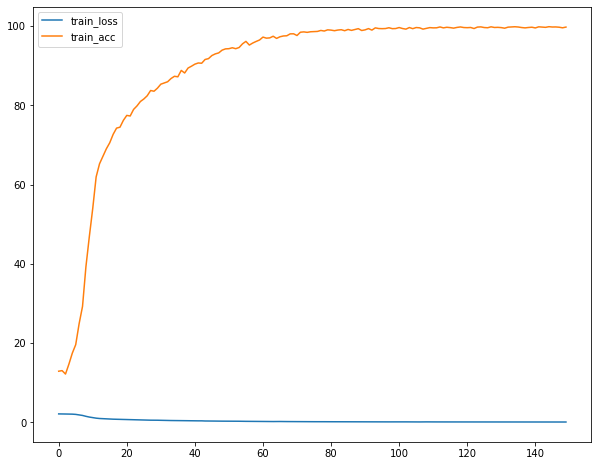

In [28]:
df_training_temp = pd.DataFrame(training_dict)
df_training = df_training_temp.transpose()
df_training.plot(figsize=(10,8))
plt.show()

In [21]:
print("Best Epoch Training Data: ")
print("Training Loss: ")
print(str(training_dict[best_epoch]['train_loss']))
print("Training Accuracy")
print(str(training_dict[best_epoch]['train_acc']))


Best Epoch Training Data: 
Training Loss: 
2.1075480757875646
Training Accuracy
12.882313829787234


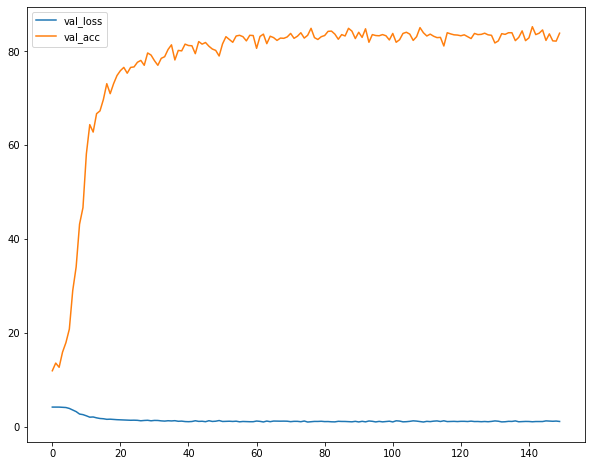

In [27]:
df_validation_temp = pd.DataFrame(validation_dict)
df_validation = df_validation_temp.transpose()
df_validation.plot(figsize=(10,8))
plt.show()

In [23]:
print("Best Epoch Validation Data: ")
print("Validation Loss: ")
print(str(validation_dict[best_epoch]['val_loss']))
print("Validation Accuracy")
print(str(validation_dict[best_epoch]['val_acc']))

Best Epoch Validation Data: 
Validation Loss: 
4.15904290335519
Validation Accuracy
11.904761904761905


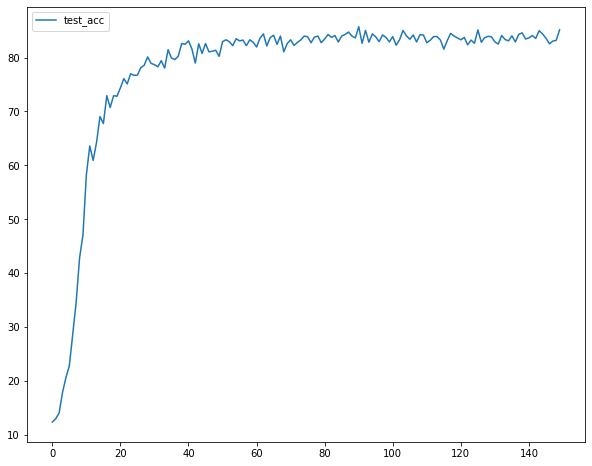

In [26]:
df_testing_temp = pd.DataFrame(testing_dict)
df_testing = df_testing_temp.transpose()
df_testing.plot(figsize=(10,8))
plt.show()

In [25]:
print("Best Epoch Testing Data: ")
print("Test Accuracy")
print(testing_dict)
print(str(testing_dict[best_epoch]['test_acc']))
epochs = testing_dict.values()
print(max([e['test_acc'] for e in epochs]))

Best Epoch Testing Data: 
Test Accuracy
{0: {'test_acc': 12.40079365079365}, 1: {'test_acc': 12.996031746031745}, 2: {'test_acc': 14.087301587301587}, 3: {'test_acc': 17.90674603174603}, 4: {'test_acc': 20.634920634920636}, 5: {'test_acc': 22.817460317460316}, 6: {'test_acc': 28.621031746031747}, 7: {'test_acc': 34.573412698412696}, 8: {'test_acc': 42.807539682539684}, 9: {'test_acc': 47.073412698412696}, 10: {'test_acc': 58.23412698412698}, 11: {'test_acc': 63.59126984126984}, 12: {'test_acc': 60.91269841269841}, 13: {'test_acc': 64.28571428571429}, 14: {'test_acc': 69.04761904761905}, 15: {'test_acc': 67.7579365079365}, 16: {'test_acc': 72.91666666666667}, 17: {'test_acc': 70.73412698412699}, 18: {'test_acc': 72.91666666666667}, 19: {'test_acc': 72.81746031746032}, 20: {'test_acc': 74.35515873015873}, 21: {'test_acc': 76.09126984126983}, 22: {'test_acc': 75.09920634920636}, 23: {'test_acc': 76.98412698412699}, 24: {'test_acc': 76.68650793650794}, 25: {'test_acc': 76.73611111111111}, 